# Metodo dei Minimi Quadrati per la stazione di Pian di Fedaia (diga)

## Consiste nel minimizzare lo scarto quadratico medio tra ECDF e la probabilità di non superamento

In [1]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import least_squares
from statsmodels.distributions.empirical_distribution import ECDF

from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
import numpy as np
from pylab import plot, show, hist,figure, title

In [2]:
os_DatiFedaia=os.getcwd()
os.chdir(os_DatiFedaia)

In [3]:
data=pd.read_csv('DatiFedaia.csv')
map(datetime,data['Anno'])
data=data.set_index('Anno')

In [4]:
data

,1h,3h,6h,12h,24h
Anno,,,,,
1919,NaN,NaN,NaN,NaN,NaN
1920,NaN,NaN,NaN,NaN,NaN
1921,NaN,NaN,NaN,NaN,NaN
1922,NaN,NaN,NaN,NaN,NaN
1923,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2006,NaN,NaN,NaN,NaN,NaN
2007,12.6,32.2,43.8,48.6,57.0
2008,40.0,50.8,61.2,83.4,91.8


### Si definisce la differenza tra ECDF e probabilità di non superamento

In [5]:
def fun(x, t, y):
    return np.exp(-np.exp(-(t-x[0])/x[1]))-y

### Si crea un dizionario delle misure di ECDF che usa come chiavi gli intervalli orari

In [6]:
ecdf={}
lst=['1h','3h','6h','12h','24h']
for i in lst:
    ecdf.update({i:ECDF(data[i].dropna())})

### Si prendono come parametri di riferimento quelli calcolati con il metodo dei Momenti

In [7]:
x0=pd.read_pickle('abs_m')

### Si calcolano i parametri con il metodo dei minimi quadrati

In [8]:
res_lsq=[]
for i in lst:    
    t_rain=sorted(data[i].dropna())                        
    y_rain=ecdf[i](t_rain) #misure di ECDF
    res_lsq_=least_squares(fun,x0[i], args=(t_rain,y_rain)) #least_squares chiede come input una funzione, x0 iniziale e gli argomenti da mettere in funzione
    res_lsq.append(res_lsq_.x)
    
abs_mq=pd.DataFrame(res_lsq,columns=["a","b"],index=lst).T
abs_mq

,1h,3h,6h,12h,24h
a,12.601354,22.782157,32.841829,49.675513,67.877296
b,3.002031,4.769872,8.015541,14.194658,24.086864


### Così si crea un file dove sono salvati i parametri appena calcolati

In [9]:
abs_mq.to_pickle('abs_mq')

### Operazioni preliminari per poter graficare i risultati

#### Definire la funzione delle curve di Gumbel

In [10]:
def gumbel(x,abs_d,col):
    return np.exp(-np.exp(-(x-abs_d[col]["a"])/abs_d[col]["b"]))

#### Definire lo spazio lineare dove graficare i risultati lungo l'ascissa

In [11]:
minimo=min(data.min()) #7.2
mass=max(data.max()) #132.6

t_rain=np.linspace(minimo,170,100) # aumento il massimo per vedere la curva tendere a 1

#### Creazione di un dataframe contenente i valori delle curve di Gumbel

In [12]:
g=[]
for i in lst:
    g.append(gumbel(t_rain,abs_mq,i))
    
gb=pd.DataFrame(g).T
gb.index=t_rain
gb.columns=lst
#gb

### Si impostano i grafici

In [13]:
import random
colors={}
for i in lst:
    colore=(random.random(), random.random(), random.random())
    colors.update({i:colore})

In [14]:
SMALL_SIZE=15
MEDIUM_SIZE=20
BIGGER_SIZE=30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

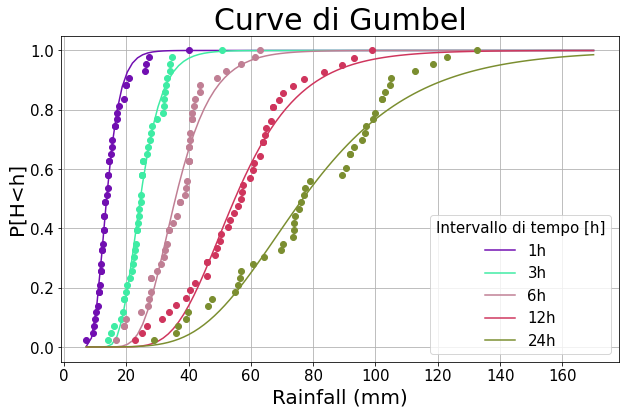

In [15]:
ax=gb.plot(figsize=(10,6),color=[colors['1h'],colors['3h'],colors['6h'],colors['12h'],colors['24h']])
for i in lst:
    ax.plot(data[i].dropna(),ecdf[i](data[i].dropna()),'o',c=colors[i])
ax.set_title('Curve di Gumbel')
ax.set_xlabel('Rainfall (mm)')
ax.set_ylabel('P[H<h]')
ax.grid(True)
ax.legend (title= "Intervallo di tempo [h]")